<a href="https://colab.research.google.com/github/CT-6282/COVID-19_Paper/blob/master/ejemplo_train_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 13 15:37:12 2020

@author: nacho
"""
import sys, os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import joblib
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
#se crea la carpeta "plots" para almecenar las grficas generadas
print(os.getcwd())
try:
    os.makedirs("plots")
except FileExistsError:
    pass
try:
    os.makedirs("models")
except FileExistsError:
    pass

/content


In [4]:
#Visualizar pca em 2D y 3D
class pca():
    def __init__(self,  df=None, titulo="Unspecified", label_y=None):
        self.df = df
        self.label_y = str(label_y)
        self.titulo = str(titulo)
        print(list(df))
        print(f"Numero de elementos de {label_y}\n", df[label_y].value_counts())
    def pca_2D(self):
        df_PCA = self.df.drop([self.label_y], axis=1)
        #instanciamos el metodo pca con 2 componentes
        pca = PCA(n_components=2)
        #encontramos los componentes principales usando 
        #el método de ajuste con 2 componentes
        #transformamos los datos scaled_data en 2 componentes con pca
        pca.fit(df_PCA)
        x_pca = pca.transform(df_PCA)
        ######
        #instanciamos un objeto para hacer PCA
        scaler = StandardScaler()
        #escalar los datos, estandarizarlos, para que cada
        #caracteristica tenga una varianza unitaria 
        scaler.fit(df_PCA)
        #aplicamos la reducción de rotación y dimensionalidad
        scaled_data = scaler.transform(df_PCA)
        pca = PCA().fit(scaled_data)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
        plt.title('How many components are needed to describe the data.')
        ######
        print("Dimension de los features orginales: ", df_PCA.shape)
        print("Dimension de los features con 2 componentes", x_pca.shape)
        
        #visualizar los datos en 2 dimensiones
        #plt.figure(figsize=(8,6))
        fig, ax = plt.subplots()
        scatter = plt.scatter(x_pca[:,0],
                    x_pca[:,1],
                    c=self.df[self.label_y],
                    cmap='rainbow',
                    marker='o',
                    s=2,
                    linewidths=0)
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".", ls="", 
                              color=scatter.cmap(scatter.norm(yi))) for yi in labels]
        plt.legend(handles, labels)
        plt.xlabel('First principal component')
        plt.ylabel('Second Principal Component')
        plt.title(self.titulo)
        #plt.show()
        plt.savefig("plots/"+self.titulo + "_2D.png",format='png', dpi=1200)
        y = self.df[self.label_y]
        return x_pca, y
    def pca_3D(self):
        sns.set_style("white")  
        self.df[self.label_y] = pd.Categorical(self.df[self.label_y])
        my_color = self.df[self.label_y].cat.codes
        df_PCA = self.df.drop([self.label_y], axis=1)
        pca = PCA(n_components=3)
        pca.fit(df_PCA)
        result=pd.DataFrame(pca.transform(df_PCA), 
                            columns=['PCA%i' % i for i in range(3)], 
                            index=df_PCA.index)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scat = ax.scatter(result['PCA0'], 
                   result['PCA1'], 
                   result['PCA2'], 
                   c=my_color, 
                   cmap='rainbow', 
                   s=2, marker="o",
                   linewidths=0)
        
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".",ls="",
                                 color=scat.cmap(scat.norm(yi))) for yi in labels]               
        ax.legend(handles, labels)
        
        # make simple, bare axis lines through space:
        xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
        ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
        yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
        ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
        zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
        ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
         
        # label the axes
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title(self.titulo)
        #plt.show()
        fig.tight_layout()
        plt.savefig("plots/"+self.titulo + "_3D.png", format='png', dpi=1200)
        y = self.df[self.label_y]
        return result, y

In [5]:
#Visualizar smv en 2d   
def plot_svm_2d(grid, X_test, Y_test):
    scaler1 = StandardScaler()
    scaler1.fit(X_test)
    X_test_scaled = scaler1.transform(X_test)
    
    
    pca1 = PCA(n_components=2)
    X_test_scaled_reduced = pca1.fit_transform(X_test_scaled)
    
    
    svm_model = SVC(kernel='rbf', C=float(grid.best_params_['SupVM__C']), 
                    gamma=float(grid.best_params_['SupVM__gamma']))
    
    classify = svm_model.fit(X_test_scaled_reduced, Y_test)
    
    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out
    
    def make_meshgrid(x, y, h=.1):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))#,
                             #np.arange(z_min, z_max, h))
        return xx, yy
    
    X0, X1 = X_test_scaled_reduced[:, 0], X_test_scaled_reduced[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    fig, ax = plt.subplots(figsize=(12,9))
    fig.patch.set_facecolor('white')
    cdict1={0:'lime',1:'deeppink'}
    
    Y_tar_list = Y_test.tolist()
    yl1= [int(target1) for target1 in Y_tar_list]
    labels1=yl1
     
    labl1={0:'Malignant',1:'Benign'}
    marker1={0:'*',1:'d'}
    alpha1={0:.8, 1:0.5}
    
    for l1 in np.unique(labels1):
        ix1=np.where(labels1==l1)
        ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])
    
    ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=40, facecolors='none', 
               edgecolors='navy', label='Support Vectors')
    
    plot_contours(ax, classify, xx, yy,cmap='seismic', alpha=0.4)
    plt.legend(fontsize=15)
    
    plt.xlabel("1st Principal Component",fontsize=14)
    plt.ylabel("2nd Principal Component",fontsize=14)
    plt.show()

In [6]:
#entrenamiento cross-validation con hiperparámetros de SVC
def gridsearchcv(X, y, n_pca=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2, stratify=y, shuffle=True)
    pipe_steps_pca = [('scaler', StandardScaler()),('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]
    param_grid_pca= {
        'pca__n_components': [n_pca], 
        'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
        'SupVM__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
    }
    pipe_steps = [('scaler', StandardScaler()), ('SupVM', SVC(kernel='rbf'))]
    param_grid= {
            'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
            'SupVM__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
    }
    if n_pca != None:
        pipeline = Pipeline(pipe_steps_pca)
        grid = GridSearchCV(pipeline, param_grid_pca,refit = True,verbose = 3, n_jobs=-1,probability=True)
    else:
        pipeline = Pipeline(pipe_steps)
        grid = GridSearchCV(pipeline, param_grid,refit = True,verbose = 3, n_jobs=-1,probability=True)
    grid.fit(X_train, Y_train)
    print("Best-Fit Parameters From Training Data:\n",grid.best_params_)
    grid_predictions = grid.predict(X_test) 
    report = classification_report(Y_test, grid_predictions, output_dict=True)
    report = pd.DataFrame(report).transpose()
    print(report)
    print(confusion_matrix(Y_test, grid_predictions))
    return grid, report, X_test, Y_test

Se importa el dataset y se guarda como un Dataframe

In [7]:
from sklearn.datasets import load_breast_cancer 
cancer = load_breast_cancer() 
df = pd.DataFrame(cancer['data'], columns = cancer['feature_names']) 
df['target'] = cancer['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']
Numero de elementos de target
 1    357
0    212
Name: target, dtype: int64
Dimension de los features orginales:  (569, 30)
Dimension de los features con 2 componentes (569, 2)


(            PCA0        PCA1       PCA2
 0    1160.142574 -293.917544  48.578398
 1    1269.122443   15.630182 -35.394534
 2     995.793889   39.156743  -1.709753
 3    -407.180803  -67.380320   8.672848
 4     930.341180  189.340742   1.374801
 ..           ...         ...        ...
 564  1414.126684  110.222492  40.065944
 565  1045.018854   77.057589   0.036669
 566   314.501756   47.553525 -10.442407
 567  1124.858115   34.129225 -19.742087
 568  -771.527622  -88.643106  23.889032
 
 [569 rows x 3 columns], 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 564    0
 565    0
 566    0
 567    0
 568    1
 Name: target, Length: 569, dtype: category
 Categories (2, int64): [0, 1])

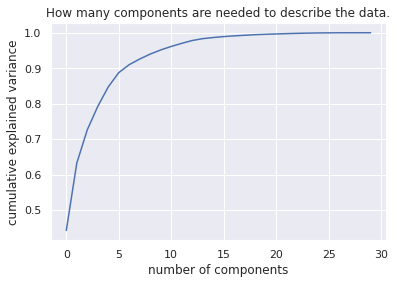

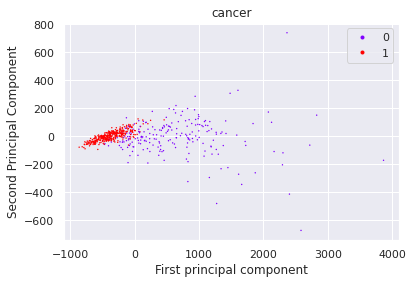

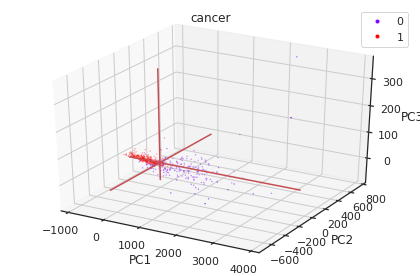

In [8]:
#visualizacion pca
cancer_pca = pca(df, titulo="cancer", label_y='target')
cancer_pca.pca_2D(); cancer_pca.pca_3D()

In [9]:
#separar datos
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
#train
cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X,y, n_pca=2)
#cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X,y)

Fitting 4 folds for each of 132 candidates, totalling 528 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 528 out of 528 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


score for 4 fold CV := 0.96
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s


score for 5 fold CV := 0.96
Best-Fit Parameters From Training Data:
 {'SupVM__C': 1000, 'SupVM__gamma': 0.01, 'pca__n_components': 2}
              precision    recall  f1-score    support
0              0.957447  0.937500  0.947368   48.00000
1              0.955224  0.969697  0.962406   66.00000
accuracy       0.956140  0.956140  0.956140    0.95614
macro avg      0.956335  0.953598  0.954887  114.00000
weighted avg   0.956160  0.956140  0.956074  114.00000
[[45  3]
 [ 2 64]]


[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:    5.3s finished


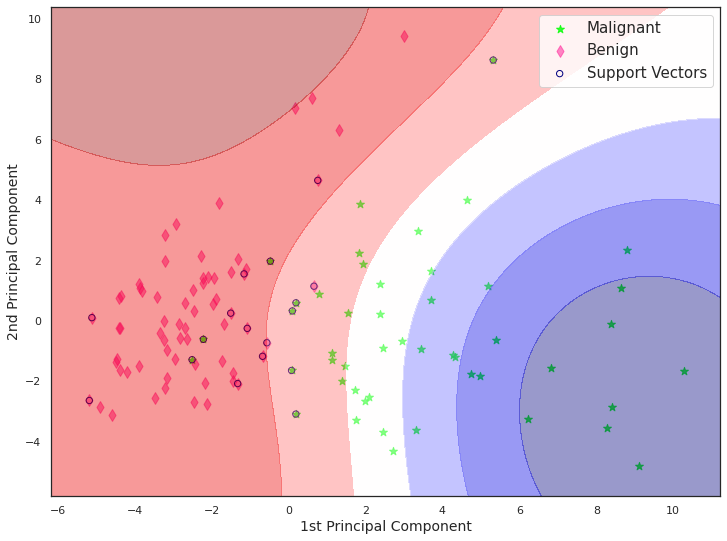

In [10]:
#grafica modelo en 2d
plot_svm_2d(cancer_grid, X_test, Y_test)

In [19]:
#guarda el mejor modelo y su rendimiento
#joblib.dump(cancer_grid.best_estimator_, 'models/cancer_grid.pkl', compress = 1)
joblib.dump(cancer_grid, 'models/cancer_grid.pkl', compress = 1)
cancer_grid_report.to_csv("models/cancer_grid_report.csv", index=True)
#importa el modelo y su rendimiento
cancer_grid_load = joblib.load('models/cancer_grid.pkl')
cancer_grid_report = pd.read_csv("models/cancer_grid_report.csv", index_col=0)

In [20]:
cancer_grid_report

,precision,recall,f1-score,support
0,0.957447,0.937500,0.947368,48.00000
1,0.955224,0.969697,0.962406,66.00000
accuracy,0.956140,0.956140,0.956140,0.95614
macro avg,0.956335,0.953598,0.954887,114.00000
weighted avg,0.956160,0.956140,0.956074,114.00000


In [25]:
input = X_test.iloc[111,:].values.reshape(1,-1) #selecciona la fila y todas las columnas excepto label
print("Input:\n",X_test.iloc[111,:])
print(Y_test.iloc[111,])
cancer_grid_load.predict(input)

Input:
 mean radius                 16.300000
mean texture                15.700000
mean perimeter             104.700000
mean area                  819.800000
mean smoothness              0.094270
mean compactness             0.067120
mean concavity               0.055260
mean concave points          0.045630
mean symmetry                0.171100
mean fractal dimension       0.056570
radius error                 0.206700
texture error                0.470600
perimeter error              1.146000
area error                  20.670000
smoothness error             0.007394
compactness error            0.012030
concavity error              0.024700
concave points error         0.014310
symmetry error               0.013440
fractal dimension error      0.002569
worst radius                17.320000
worst texture               17.760000
worst perimeter            109.800000
worst area                 928.200000
worst smoothness             0.135400
worst compactness            0.136100
wors

array([1])

Actividad:


> Probar el entrenamiento y comparar su rendimiento con 3 PCA y sin PCA

¿Cual seria el numero de PCA ideal y porque elegirlo en lugar de no usarlo?

